# 10章
- 以下で実行するコードには確率的な処理が含まれていることがあり、コードの出力結果と本書に記載されている出力例が異なることがあります。

In [2]:
# 10-1
!mkdir chap10
%cd ./chap10

/content/chap10/chap10


In [3]:
!pip install -U pip==23.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [4]:
# 10-2
!pip install transformers==4.18.0 fugashi==1.1.0 ipadic==1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 994.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.9/336.9 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 37.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 49.9 MB/s eta 0:00:00
  Created wheel for fugashi: filename=fugashi-1.1.0-cp310-cp310-linux_x86_64.whl size=257490 sha256=b8f82e2fd602653311dd36388795b1069fbdd22759eb0b4c4e0ffe20192d36ad
  Stored in directory: /root/.cache/pip/wheels/f6/bc/9b/6d38a64c5bea6582a87574f5c63b6c0bd9a4f5a6706ed577a5
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=a272c1cd901bed5234af49b67d1793d507bd988b173bc10dc06e96184d318cae
  Stored in d

In [5]:
# 10-3
import random
import glob
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel

# BERTの日本語モデル
MODEL_NAME = 'tohoku-nlp/bert-base-japanese-whole-word-masking'

In [6]:
# 10-4
#データのダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
#ファイルの解凍
!tar -zxf ldcc-20140209.tar.gz

--2024-09-20 07:20:56--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  3.29MB/s    in 2.6s    

2024-09-20 07:20:59 (3.29 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]



In [7]:
# 10-5
# カテゴリーのリスト
category_list = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]

# トークナイザとモデルのロード
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model = model.cuda()

# 各データの形式を整える
max_length = 256
sentence_vectors = [] # 文章ベクトルを追加していく。
labels = [] # ラベルを追加していく。
for label, category in enumerate(tqdm(category_list)):
    for file in glob.glob(f'./text/{category}/{category}*'):
        # 記事から文章を抜き出し、符号化を行う。
        lines = open(file).read().splitlines()
        text = '\n'.join(lines[3:])
        encoding = tokenizer(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        encoding = { k: v.cuda() for k, v in encoding.items() }
        attention_mask = encoding['attention_mask']

        # 文章ベクトルを計算
        # BERTの最終層の出力を平均を計算する。（ただし、[PAD]は除く。）
        with torch.no_grad():
            output = model(**encoding)
            last_hidden_state = output.last_hidden_state
            averaged_hidden_state = \
                (last_hidden_state*attention_mask.unsqueeze(-1)).sum(1) \
                / attention_mask.sum(1, keepdim=True)

        # 文章ベクトルとラベルを追加
        sentence_vectors.append(averaged_hidden_state[0].cpu().numpy())
        labels.append(label)

# それぞれをnumpy.ndarrayにする。
sentence_vectors = np.vstack(sentence_vectors)
labels = np.array(labels)

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/120 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:349: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

In [8]:
# 10-6
sentence_vectors_pca = PCA(n_components=2).fit_transform(sentence_vectors)
print(sentence_vectors_pca.shape)

(7367, 2)


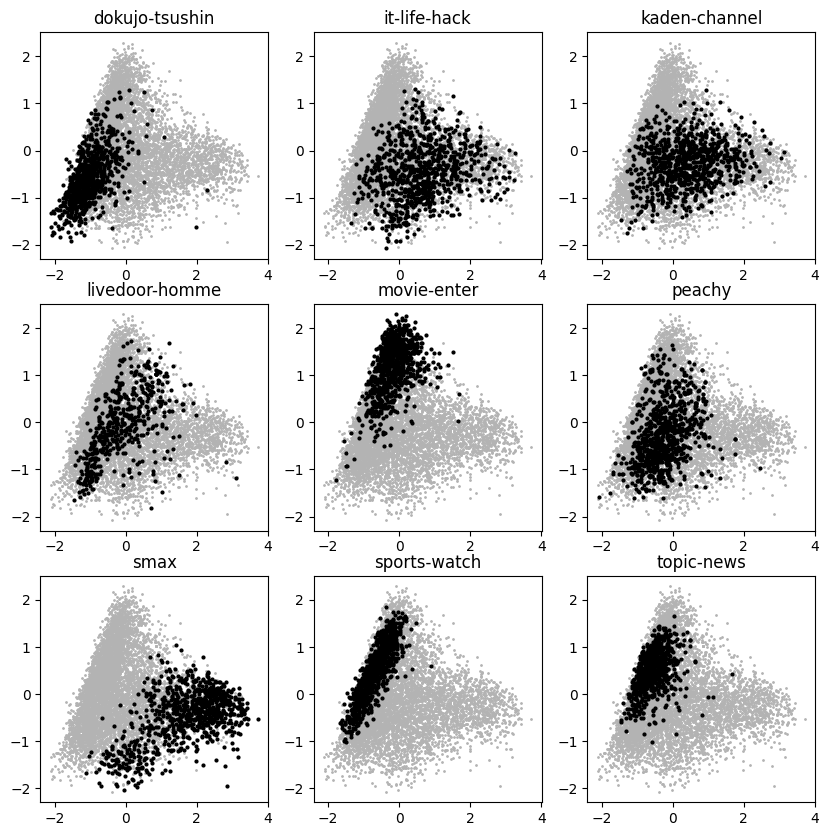

In [9]:
# 10-7
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_pca[:,0],
        sentence_vectors_pca[:,1],
        'o',
        markersize=1,
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_pca[index,0],
        sentence_vectors_pca[index,1],
        'o',
        markersize=2,
        color='k'
    )
    plt.title(category_list[label])

In [10]:
# 10-8
sentence_vectors_tsne = TSNE(n_components=2).fit_transform(sentence_vectors)

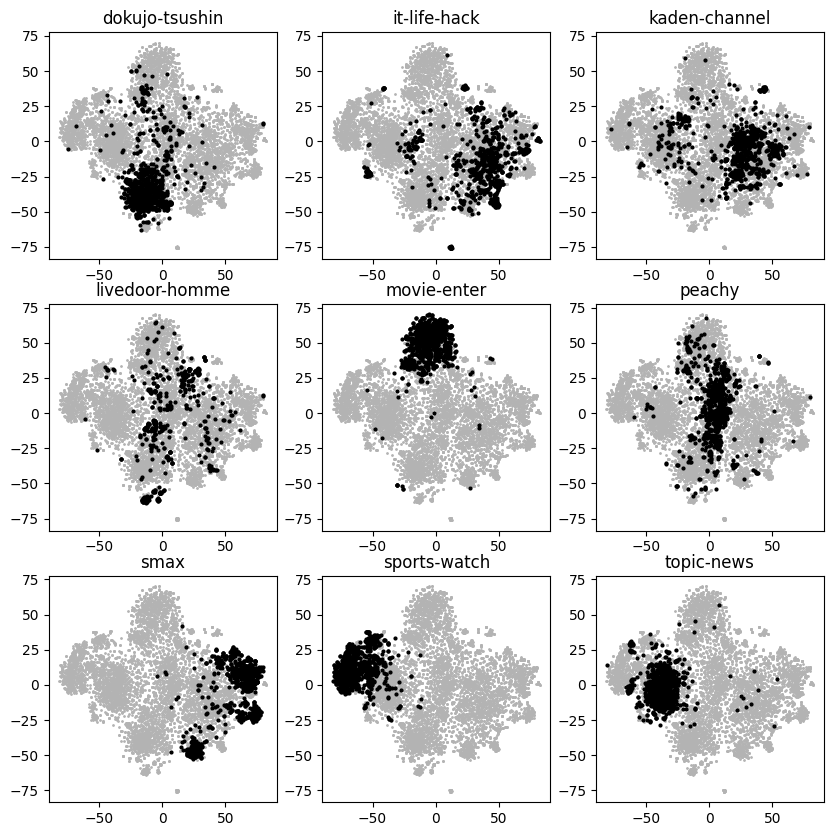

In [11]:
# 10-9
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_tsne[:,0],
        sentence_vectors_tsne[:,1],
        'o',
        markersize=1,
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_tsne[index,0],
        sentence_vectors_tsne[index,1],
        'o',
        markersize=2,
        color='k'
    )
    plt.title(category_list[label])

In [12]:
# 10-10
# 先にノルムを1にしておく。
norm = np.linalg.norm(sentence_vectors, axis=1, keepdims=True)
sentence_vectors_normalized = sentence_vectors / norm

# 類似度行列を計算する。
# 類似度行列の(i,j)要素はi番目の記事とj番目の記事の類似度を表している。
sim_matrix = sentence_vectors_normalized.dot(sentence_vectors_normalized.T)

# 入力と同じ記事が出力されることを避けるため、
# 類似度行列の対角要素の値を小さくしておく。
np.fill_diagonal(sim_matrix, -1)

# 類似度が高い記事のインデックスを得る
similar_news = sim_matrix.argmax(axis=1)

# 類似文章検索により選ばれた記事とカテゴリーが同一であった記事の割合を計算
input_news_categories = labels
output_news_categories = labels[similar_news]
num_correct = ( input_news_categories == output_news_categories ).sum()
accuracy = num_correct / labels.shape[0]

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83
